In [56]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math
import scipy.special as ss
ň = None
from collections import namedtuple
rs2 = math.sqrt(.5)

In [95]:
# "Fake multipoles" consist of a list constituent dipoles 
# (their powers/directions and relative placements)
# One radiating "particle" is represented by its center position, a list of FakeMultipoles, and a corresponding list of excitation coefficients
FMPart = namedtuple("FMPart", ["dipole", "offset"])
class FakeMultipole:
    def __init__(self, partlist):
        self.parts = partlist
    
    def __repr__(self):
        return "FakeMultipole("+repr(self.parts)+")"
        
    @staticmethod
    def DipX():
        return FakeMultipole((FMPart((1.,0.),(0.,0.)),))
    
    @staticmethod
    def DipY():
        return FakeMultipole((FMPart((0.,1.),(0.,0.)),))
    
    @staticmethod
    def QuadXYPar(r):
        '''
         🡣
        🡠 🡢
         🡡
        '''
        return FakeMultipole((
            FMPart(( 1., 0.),(  r, 0.)),
            FMPart((-1., 0.),( -r, 0.)),
            FMPart(( 0., 1.),( 0., -r)),
            FMPart(( 0.,-1.),( 0.,  r)),
        ))
    
    @staticmethod
    def QuadXYDiag(r):
        '''
        🡤 🡧
        🡥 🡦
        '''
        return FakeMultipole((
            FMPart((-rs2, rs2),(-rs2*r, rs2*r)),
            FMPart((-rs2,-rs2),( rs2*r, rs2*r)),
            FMPart(( rs2, rs2),(-rs2*r,-rs2*r)),
            FMPart(( rs2,-rs2),( rs2*r,-rs2*r)),
        ))

def FloatTuple(x): # normal form to be used as key
    return tuple(float(xx) for xx in x)

def MultipoleSource(fakemultipoles, facs):
    '''
    TODO description
    returns two numpy arrays of size (N, 2): offsets, dipoles
    offsets are relative to "particle center", so one can add an overall particle position to that
    dipoles can be multiplied e.g. by an overall phase
    '''
    # find unique offsets
    offsets = {FloatTuple(p.offset) for fakemultipole in fakemultipoles for p in fakemultipole.parts }
    # evaluate the overall dipole for each offset
    dipoles = {k : np.zeros((2,)) for k in offsets}
    for fac, fakemultipole in zip(facs, fakemultipoles):
        for dipole, offset in fakemultipole.parts:
            dipoles[FloatTuple(offset)] += fac * np.array(dipole)
    # flatten the result, ignoring parts which are zero for a given offset
    res_offsets = []
    res_dipoles = []
    for offset, dipole in dipoles.items():
        if np.any(dipole):
            res_offsets.append(offset)
            res_dipoles.append(dipole)
    return np.array(res_offsets), np.array(res_dipoles)

            

In [58]:
# MultipoleSource([FakeMultipole.QuadXYPar(0.2), FakeMultipole.DipX(), FakeMultipole.DipY()],[4, 1, 1])

In [138]:
# El. field in Airy disk behaves as J(x)/x where x = r п 

def plot_intensity_predict(
    NA = 1.1,
    nx = 60,
    ny = 60,
    ssl = 60/6, # square edge length in image pixels
    offset = (0.0000,0.0000), # offset of (some) A-site in pixels , TODO probably remove
    kmultiplier = 0.5, # wave vector length relative to the |Γ1 - Γ0| length (0.5 for X1 "beams")
    wangle = np.pi*(1/2+np.arange(4)/2), # wave directions w.r.t. X-axis
    phases = (0,0,0,0),
    # This will now be more complicated: facs array is now twodimensional: 
    # first dimension corresponds to k-vector index (i.e. wave propagation direction),
    # second dimension corresponds to multipole index (as in `basis`)
    # also, the polarisation (the `up` direction) is now not rotated inside the function according to the wave direction
    # but must be provided "by the caller" via facs
    # FIXME / TODO: PROPER SUPERPOSITION IS NOT IMPLEMENTED YET, SEE wi WHICH CURRENTLY SELECTS ONE PARTICULAR WAVE DIRECTION
    basis = [FakeMultipole.DipX(), FakeMultipole.DipY(), FakeMultipole.QuadXYPar(.11), FakeMultipole.QuadXYDiag(.11)],
    facs = #((-1,-1,1,1)),
        np.array((1,0,1,0))[:,ň] * np.array([0,1,0,0])[ň,:],
    wi = 0, #TODO THIS WILL GO AWAY
    ascale=6, # arrow scale
    gphase=1,
    # xx transversal=True, # whether the (in-plane) el. field direction is perpendicular to the (in-plane part of) wave vector
    rs_intensity_cmap = "gist_gray", sitecolor = 'grey',arrowcolor = 'red',proj_arrowcolor='red',
    proj_angle = None, # polarisation filtering: project the result vector fields onto this direction (None for no filter)
    show_dipoles = True, # show the original 
    show_axes = False,
    xjfactor = 1,
):
    
    offset = np.array(offset)
    scale_units = 'width'
    gphase = np.array(gphase)
    gphase = np.ravel(gphase)
    phases = np.array(phases, dtype=float) + gphase
    facs = np.array(facs)
    
    # set up direct lattice
    # finite lattice size
    n1 = math.ceil(nx / ssl * 2) * 2
    n2 = math.ceil(ny / ssl * 2) * 2
    # basis vectors
    b1 = np.array((ssl,0))
    b2 = np.array((0,ssl))
    # positions
    sites = np.arange(-n1,n1)[:,ň,ň] * b1[ň,ň,:] + np.arange(-n2,n2)[ň,:,ň] * b2[ň,ň,:]
    sites = np.reshape(sites,(np.prod(sites.shape[:-1]), sites.shape[-1])) # shape == ()
    sites_s = sites + offset
    
    
    # set up wave vectors and phases at sites
    klen = 2 * np.pi / ssl * kmultiplier #in-plane wavevector length
    #wlen = 2*np.pi/Xlen
    # XX upangle = wangle + pp*transversal # in-plane wave field polarisation direction
    wavevector = klen * np.stack((np.cos(wangle),np.sin(wangle)), axis=-1)
    # XX #this is for dipole polarisations, TODO generalise for multipoles
    # XX up = np.stack((np.cos(upangle),np.sin(upangle)), axis=-1) 
    # removing lattice sites, but why? Probably more relevant for non-square lattices
    if False:
        cn = 4
        sites = sites[(sites_s[...,0] <= nx+cn*ssl) 
                       *(sites_s[...,0] >= -cn*ssl) 
                       *(sites_s[...,1] <= ny+cn*ssl)
                       *(sites_s[...,1] >= -cn*ssl)]
        sites_s = sites + offset

    phase = np.tensordot(wavevector, sites, axes=(-1,-1))-phases[:,ň] # ([wi,/x/]*[site,/x/])-[wi, ň] ~ [wi,site]
    # TODO superpositions everywhere, get rid of wi
    soffsets, sdipoles = MultipoleSource(basis, facs[wi])
    dipsites = (sites_s[:,ň,:] + soffsets[ň,:,:])
    dipoles = np.exp(1j*phase[wi,:,ň,ň]) * sdipoles[ň,:,:]
    
    sites_s = dipsites.reshape((-1,2))
    wave = dipoles.reshape((-1,2)).real
                
    # XX dipole polarisations of the resulting wave (incl. coefficients) at the lattice sites, TODO generalise for quadrupoles etc.
    # XX these serve as the light "sources"
    # XX wave = np.sum(np.exp(1j*phase)[:, :, ň] * up[:, ň, :] * facs[:, ň, ň], axis=0).real # [gpi,/wi/,site,ň]*[/wi/,ň,x]*[/wi/,ň,ň] ~ [site,x]
    if proj_angle is not None:
        pv = np.array((math.cos(proj_angle),math.sin(proj_angle)), dtype=float)
        wave_proj = np.tensordot(wave, pv, axes=(-1,-1))
        wave_proj = wave_proj[...,ň] * pv
        wave_proj*=(abs(wave_proj)>1e-13) # filter away roundoff errors
    else: 
        wave_proj = wave
    wave = wave_proj
    
    my = np.arange(ny)
    mx = np.arange(nx)
    xj = np.sqrt((sites_s[:,0,ň,ň]-mx[ň,ň,:])**2 + (sites_s[:,1,ň,ň]-my[ň,:,ň])**2) * xjfactor #arbitrary factor, FIXME
    
    xj[np.isnan(xj)]=0
    xj *= 2*np.pi*NA/klen
    U = ss.j1(xj)/xj # FIXME possible division by zero; site,my,mx
    U = U[:,ň,:,:] * wave[:,:,ň,ň] # site,x,my,mn
    U = np.sum(U,axis=0) # x, my, mn
    intensity = U[0]**2+U[1]**2 #[my,mn]

    f, ax = plt.subplots(figsize=(10,10))
    ax.imshow(intensity, cmap=rs_intensity_cmap)

    ax.scatter(sites_s[:,0], sites_s[:,1], marker='o', edgecolors=sitecolor, facecolors='none', s=ssl**2/nx/ny*2500)
    if show_dipoles:
        cax = ax.quiver(sites_s[:,0],sites_s[:,1],wave[:,0],wave[:,1],color=arrowcolor,headwidth=3, scale_units = scale_units, scale=ascale, pivot='mid')
    if proj_angle is not None:
        pcax = ax.quiver(sites_s[:,0],sites_s[:,1],wave_proj[:,0],wave_proj[:,1],color=proj_arrowcolor,headwidth=3, scale_units = scale_units, scale=ascale, pivot='mid', width=.01)      
    ax.set_xlim(-0.5,nx-0.5)
    ax.set_ylim(-0.5,ny-0.5)
    if not show_axes:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
    return f, ax, wave, intensity

In [158]:
angles = [
    ("unpolarised", None),
    ("0 ° (x)", 0),
    ("45 °", np.pi/4),
    ("90 ° (y)", np.pi/2),
]
xjfactor = 0.05

<ipython-input-138-0959a8f96dab>:95: RuntimeWarning: invalid value encountered in true_divide
  U = ss.j1(xj)/xj # FIXME possible division by zero; site,my,mx


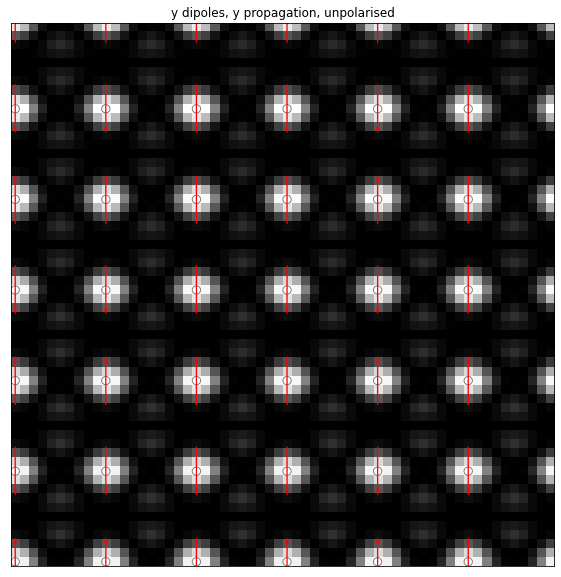

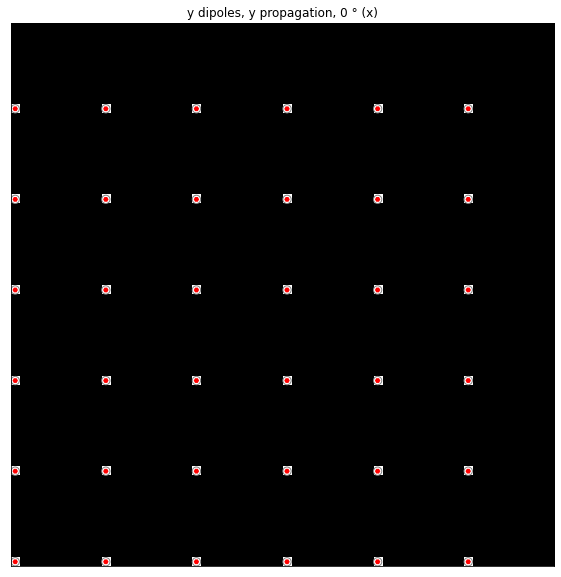

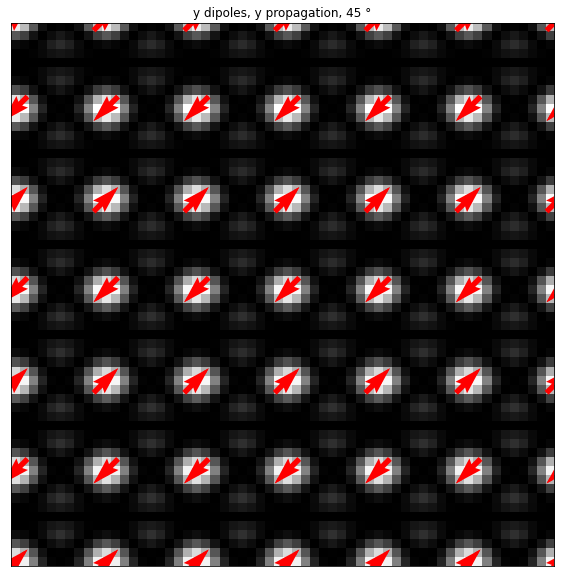

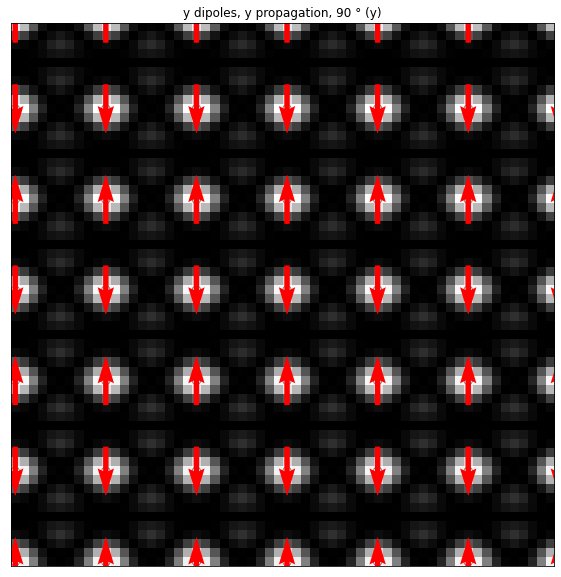

In [170]:

for (alabel, angle) in angles:
    f,ax,wave,intensity=plot_intensity_predict(xjfactor = xjfactor, proj_angle = angle)
    ax.set_title("y dipoles, y propagation, " + alabel)


<ipython-input-138-0959a8f96dab>:95: RuntimeWarning: invalid value encountered in true_divide
  U = ss.j1(xj)/xj # FIXME possible division by zero; site,my,mx


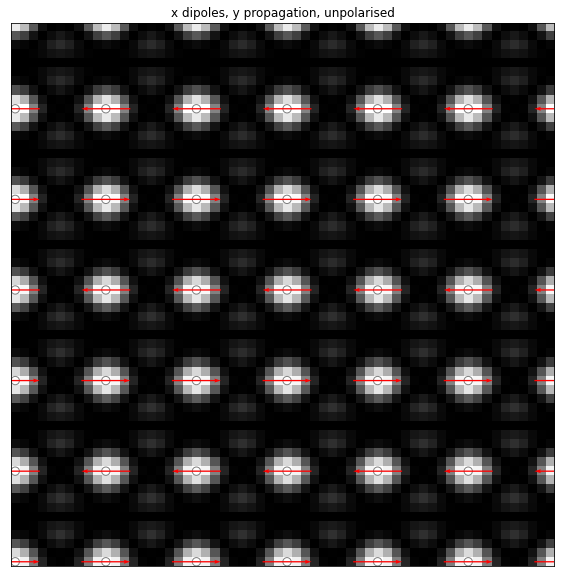

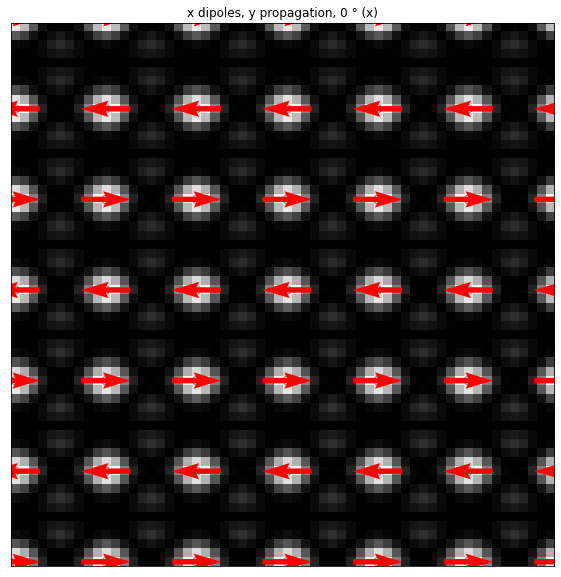

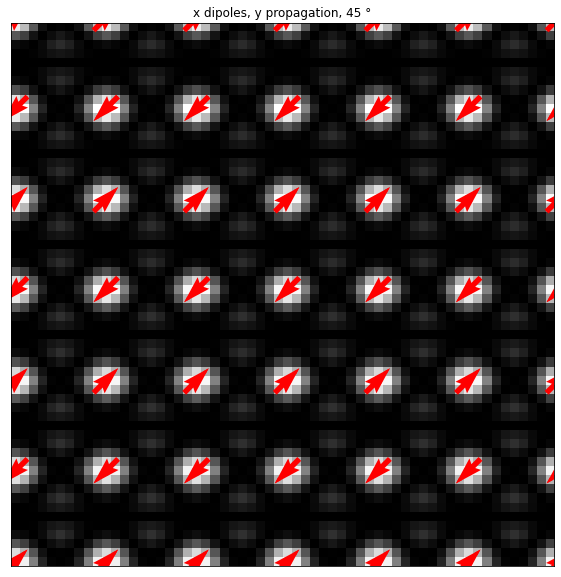

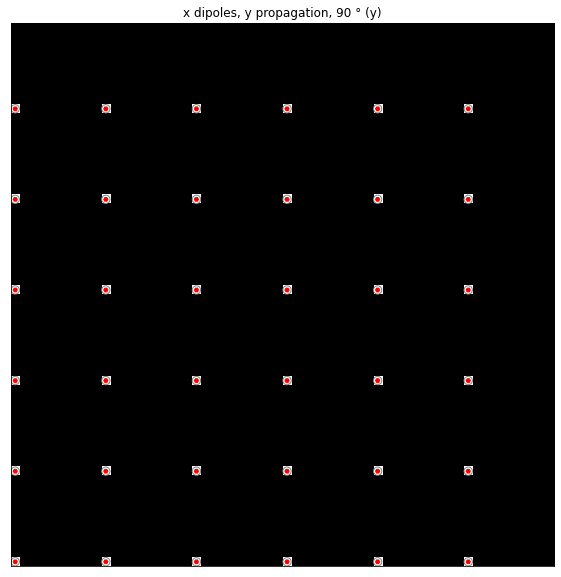

In [172]:
for (alabel, angle) in angles:
    f,ax,wave,intensity=plot_intensity_predict(
        facs = np.array((1,0,0,0))[:,ň] * np.array([1,0,0,0])[ň,:],
        wi = 0, xjfactor = xjfactor, proj_angle = angle)
    ax.set_title("x dipoles, y propagation, " + alabel)

<ipython-input-138-0959a8f96dab>:95: RuntimeWarning: invalid value encountered in true_divide
  U = ss.j1(xj)/xj # FIXME possible division by zero; site,my,mx


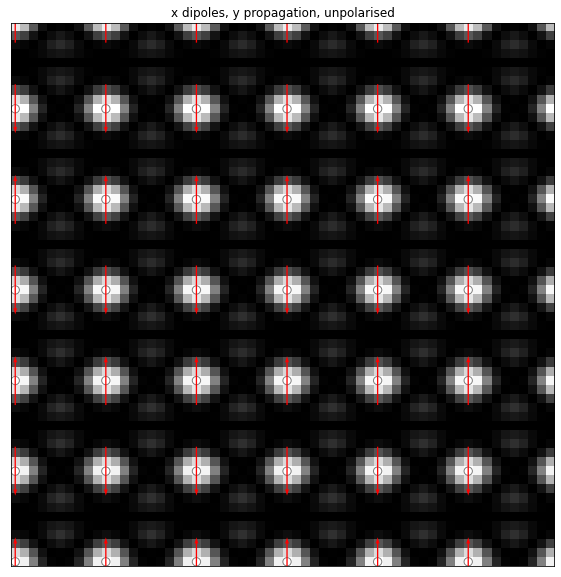

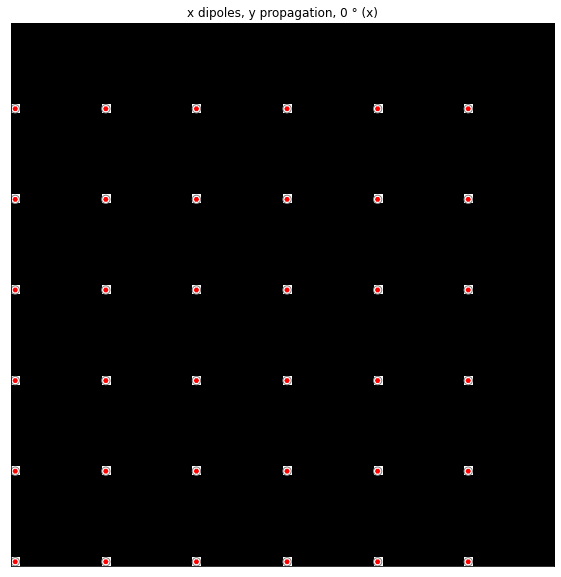

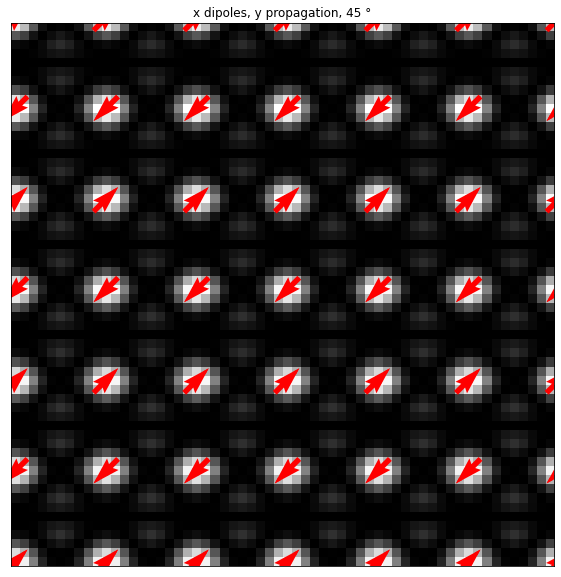

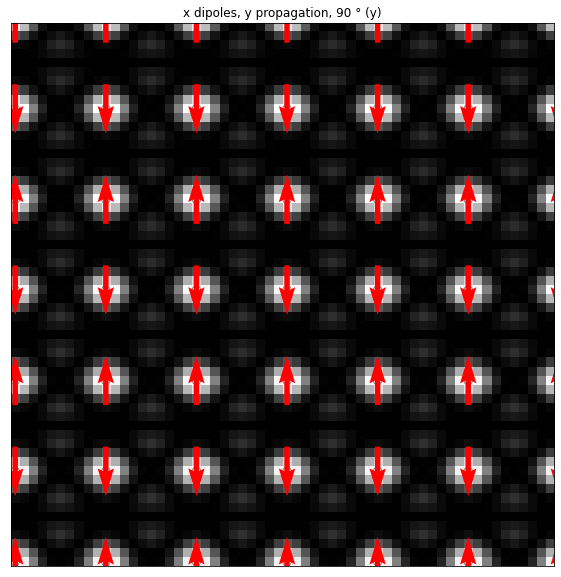

In [173]:
for (alabel, angle) in angles:
    f,ax,wave,intensity=plot_intensity_predict(
        facs = np.array((1,0,0,0))[:,ň] * np.array([0,1,0,0])[ň,:],
        wi = 0, xjfactor = xjfactor, proj_angle = angle)
    ax.set_title("y dipoles, y propagation, " + alabel)

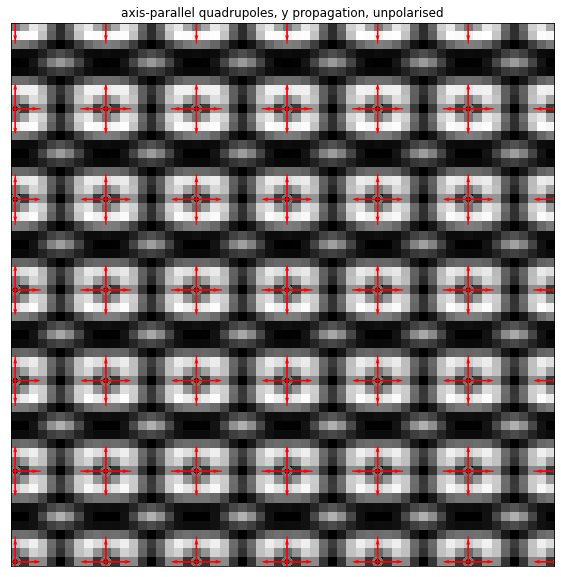

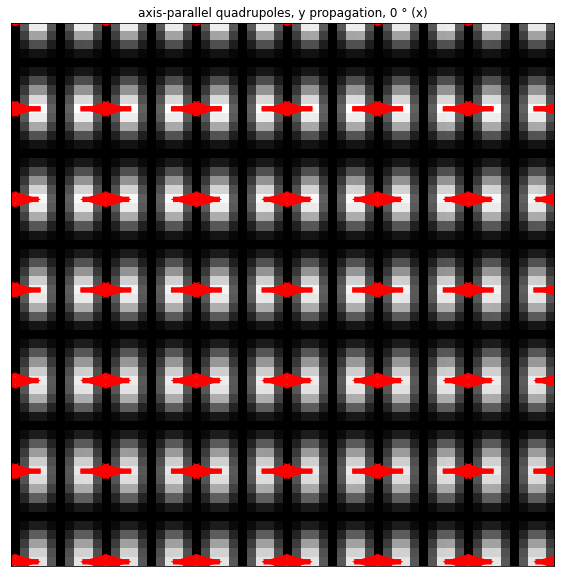

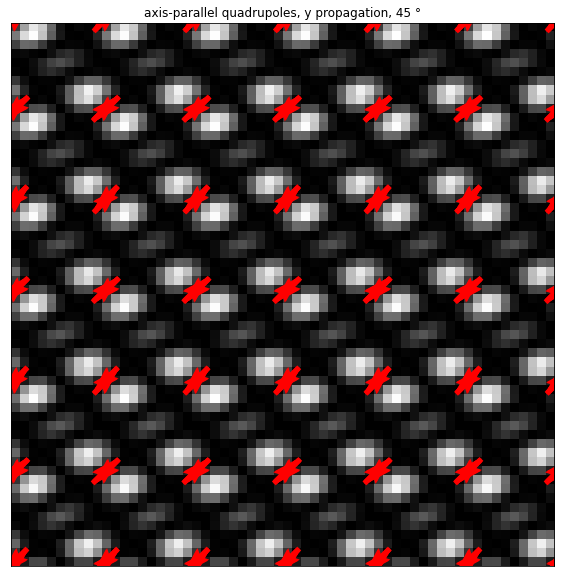

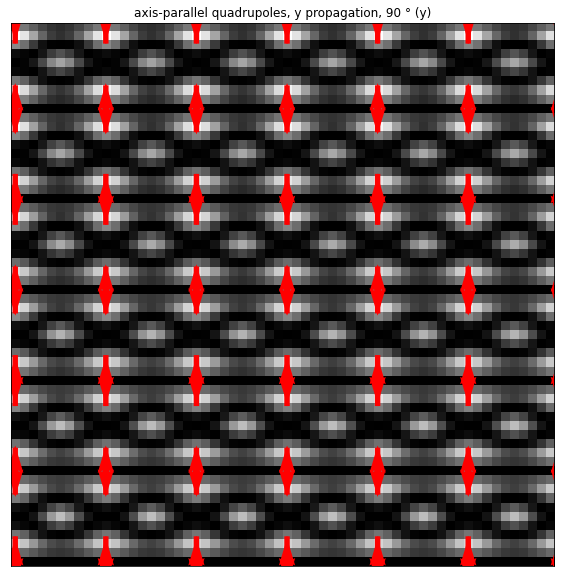

In [174]:
for (alabel, angle) in angles:
    f,ax,wave,intensity=plot_intensity_predict(
        facs = np.array((1,0,0,0))[:,ň] * np.array([0,0,1,0])[ň,:],
        wi = 0, xjfactor = xjfactor, proj_angle = angle)
    ax.set_title("axis-parallel quadrupoles, y propagation, " + alabel)

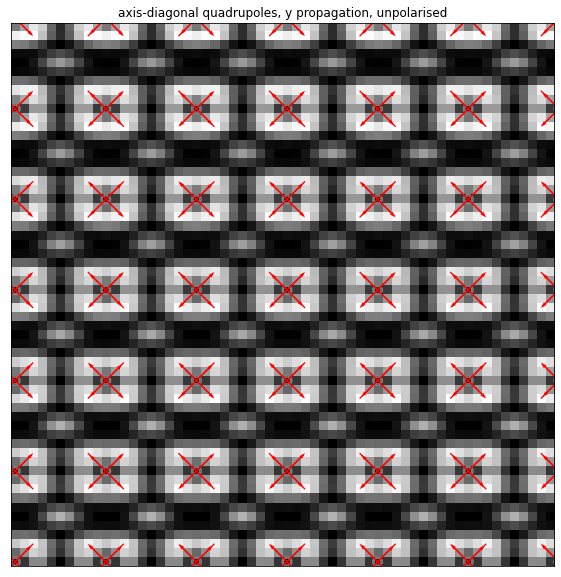

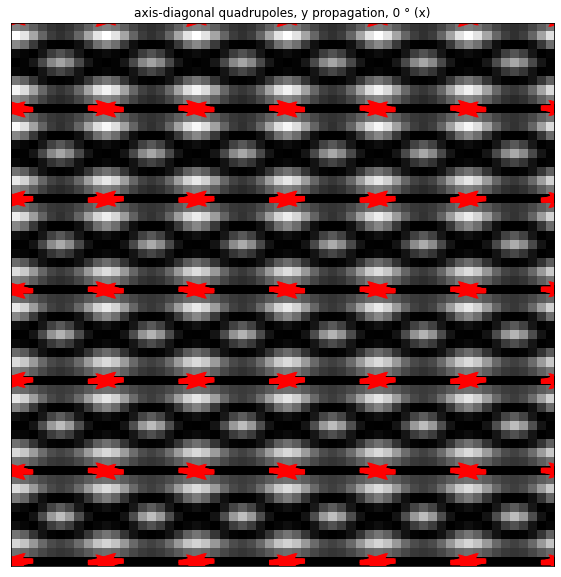

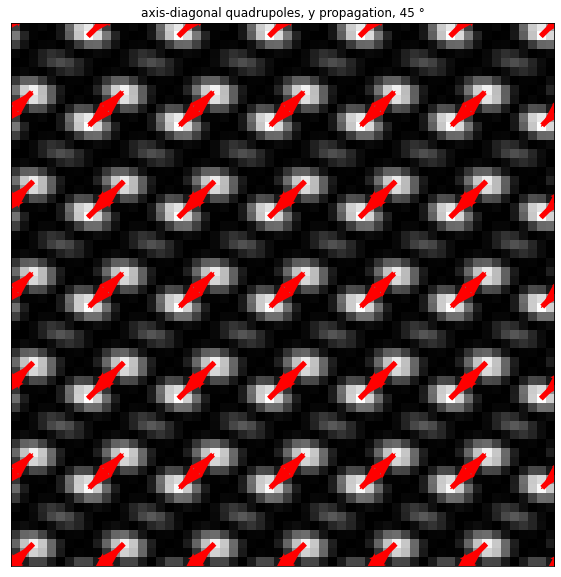

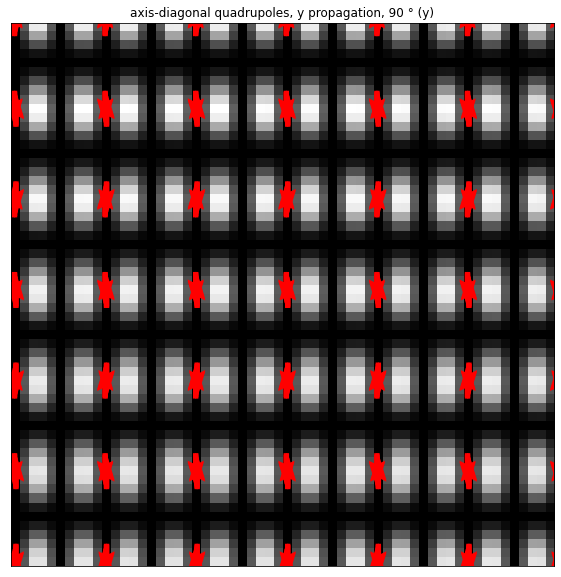

In [175]:
for (alabel, angle) in angles:
    f,ax,wave,intensity=plot_intensity_predict(
        facs = np.array((1,0,0,0))[:,ň] * np.array([0,0,0,1])[ň,:],
        wi = 0, xjfactor = xjfactor, proj_angle = angle)
    ax.set_title("axis-diagonal quadrupoles, y propagation, " + alabel)

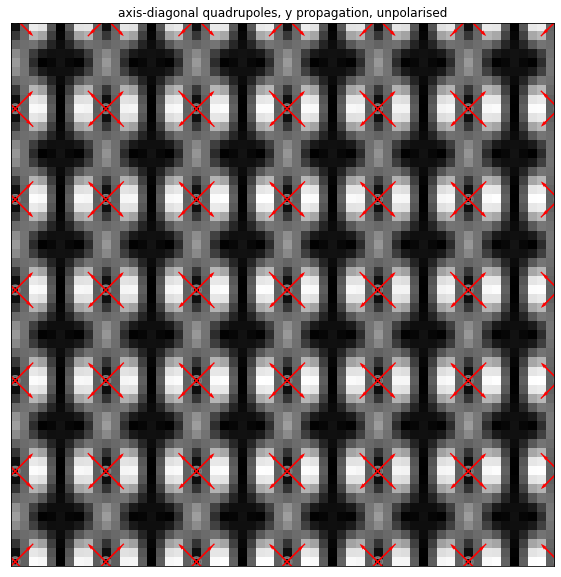

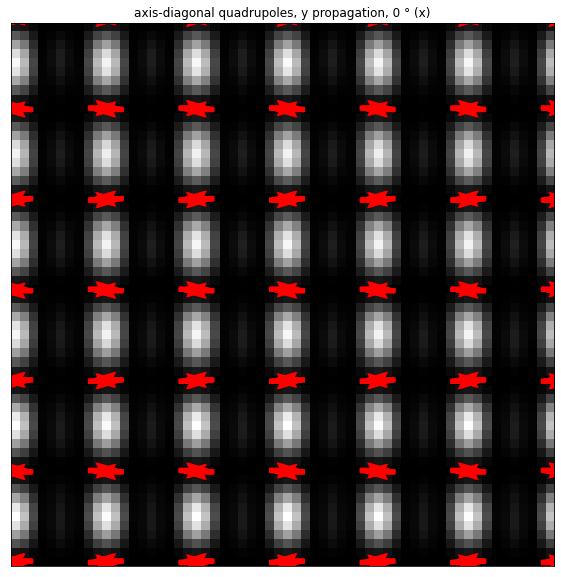

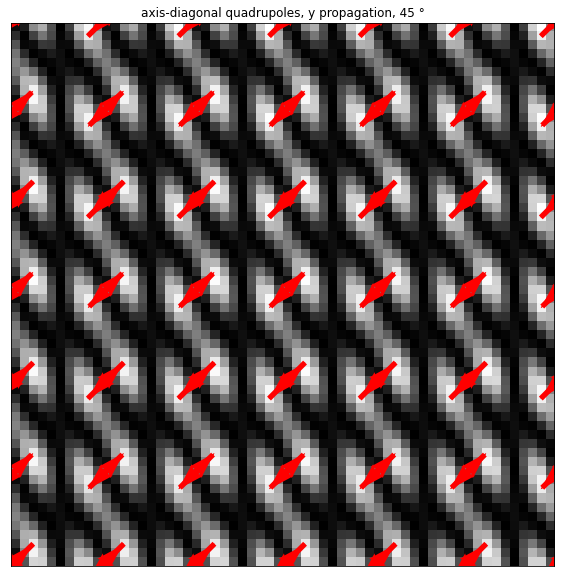

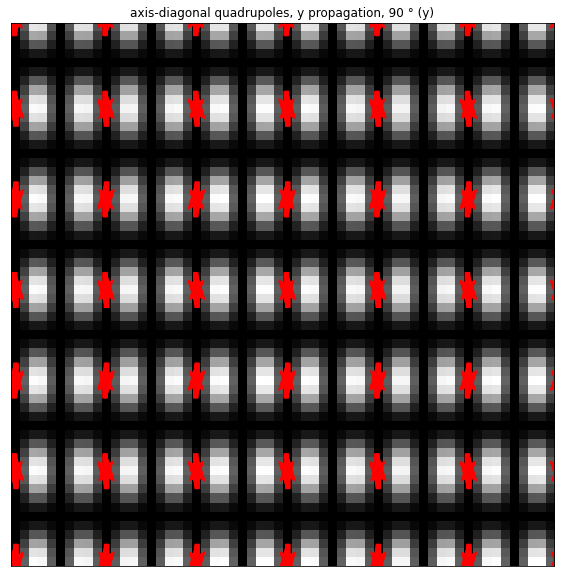

In [179]:
for (alabel, angle) in angles:
    f,ax,wave,intensity=plot_intensity_predict(
        facs = np.array((1,0,0,0))[:,ň] * np.array([0,0,0,1])[ň,:],
        wi = 0, xjfactor = 0.04, proj_angle = angle)
    ax.set_title("axis-diagonal quadrupoles, y propagation, " + alabel)

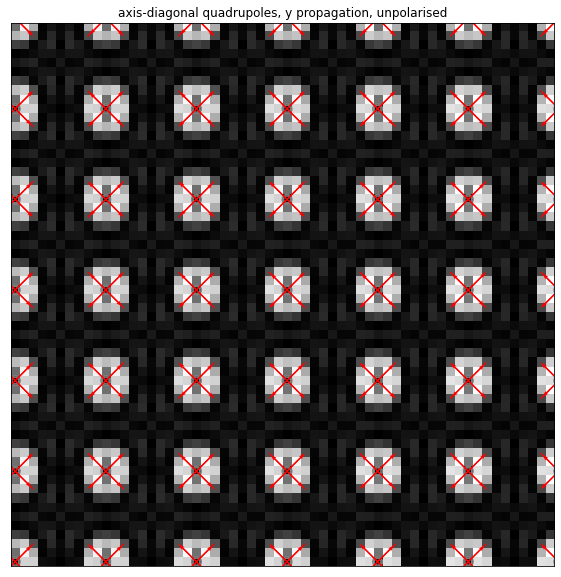

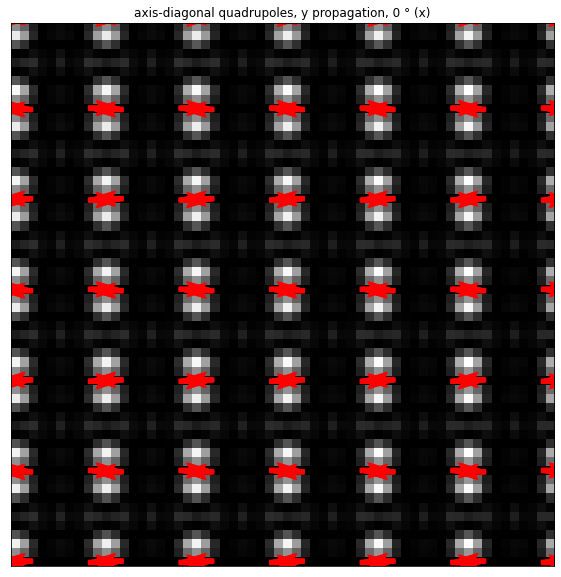

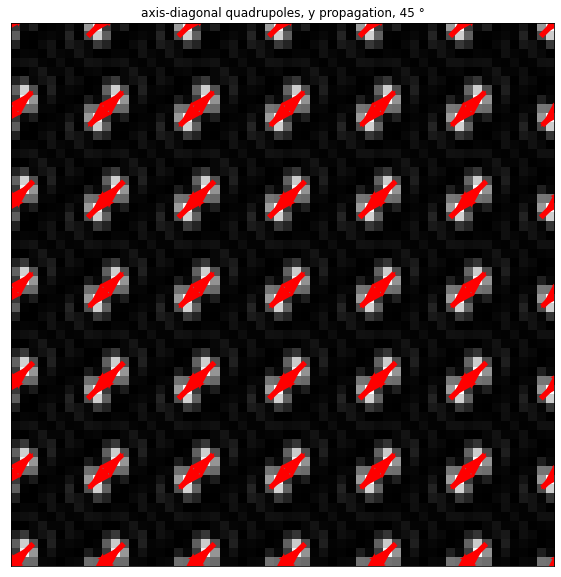

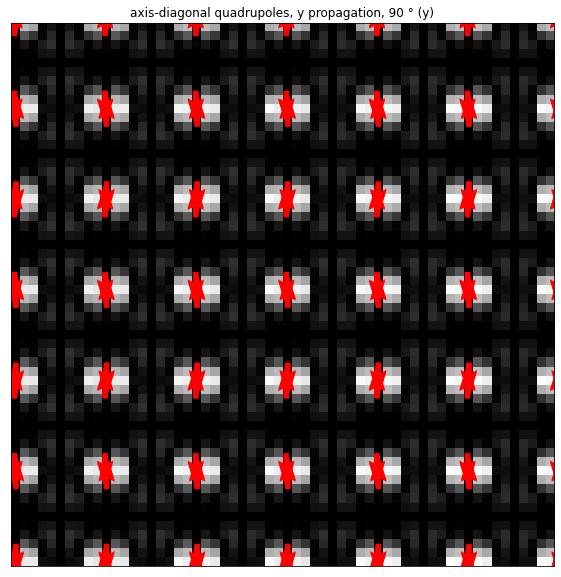

In [181]:
for (alabel, angle) in angles:
    f,ax,wave,intensity=plot_intensity_predict(
        facs = np.array((1,0,0,0))[:,ň] * np.array([0,0,0,1])[ň,:],
        wi = 0, xjfactor = 0.07, proj_angle = angle)
    ax.set_title("axis-diagonal quadrupoles, y propagation, " + alabel)

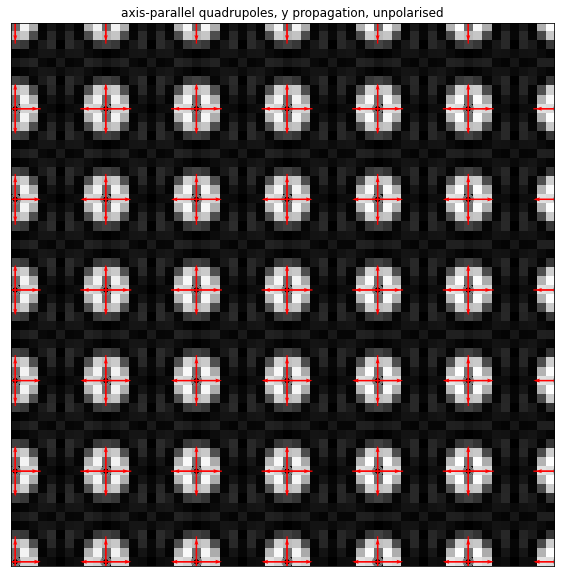

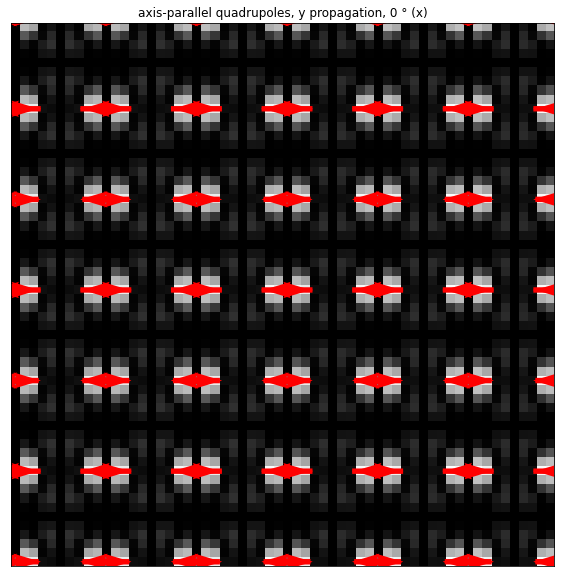

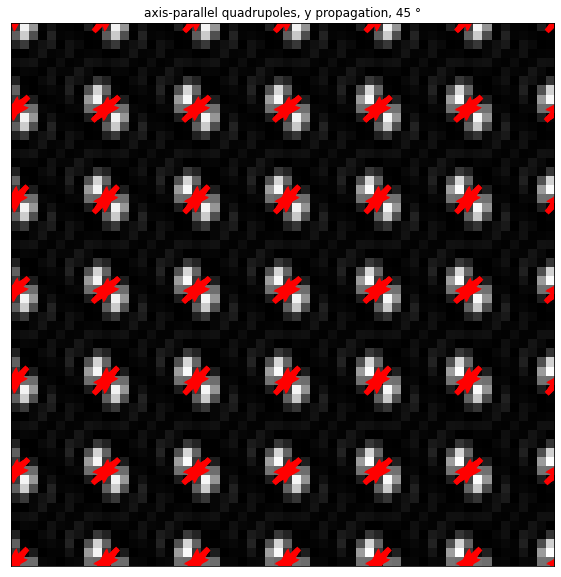

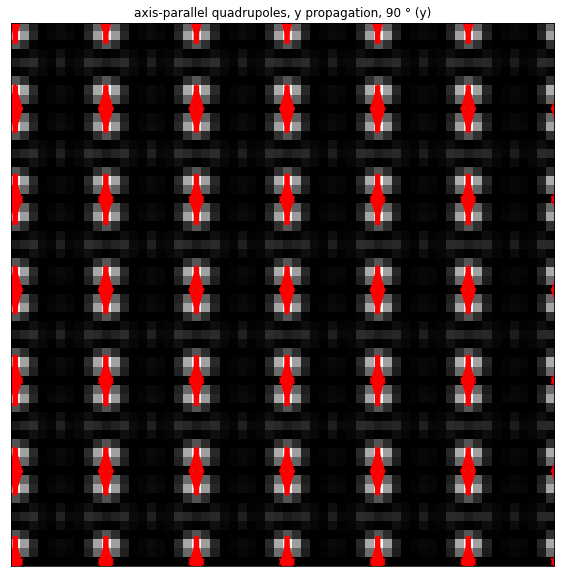

In [182]:
for (alabel, angle) in angles:
    f,ax,wave,intensity=plot_intensity_predict(
        facs = np.array((1,0,0,0))[:,ň] * np.array([0,0,1,0])[ň,:],
        wi = 0, xjfactor = 0.07, proj_angle = angle)
    ax.set_title("axis-parallel quadrupoles, y propagation, " + alabel)

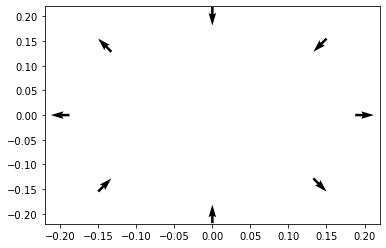

In [143]:
offsets, dips = MultipoleSource([FakeMultipole.QuadXYPar(0.2), FakeMultipole.QuadXYDiag(0.2), FakeMultipole.DipX(), FakeMultipole.DipY()],[4, 4, 0, 0])
plt.quiver(offsets[:,0], offsets[:,1], dips[:,0], dips[:,1], pivot='mid')